<a href="https://colab.research.google.com/github/davimcabral/NonStationarityInFinancialTS/blob/main/graphic_sp500_vix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

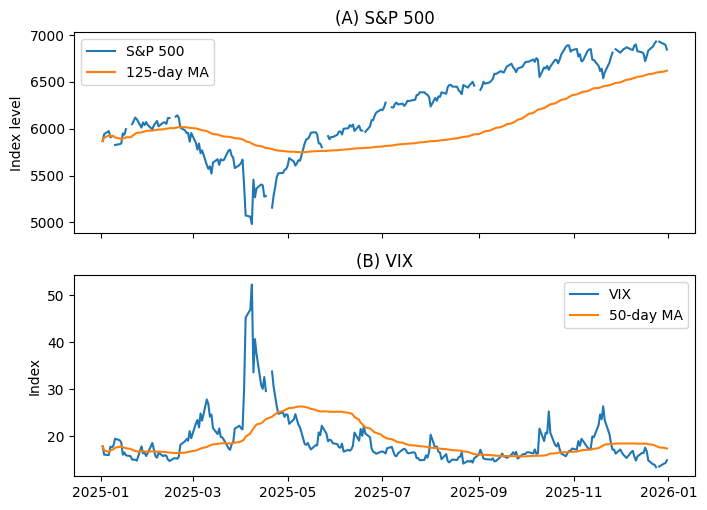

In [4]:
import io
import requests
import pandas as pd

def fred_graph_csv(series_id: str) -> pd.Series:
    url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}"
    r = requests.get(url, timeout=30)
    r.raise_for_status()

    text = r.text.strip()

    # Se por algum motivo veio HTML (bloqueio/erro), isso evita erro silencioso
    if text.lower().startswith("<!doctype html") or text.lower().startswith("<html"):
        raise RuntimeError("FRED returned HTML instead of CSV. Try again later or check connectivity.")

    df = pd.read_csv(io.StringIO(text))

    # Normaliza nomes de colunas (remove espaços e BOM)
    df.columns = [c.strip().lstrip("\ufeff") for c in df.columns]

    # Descobre coluna de data (DATE / observation_date / primeira coluna)
    date_col = None
    for c in df.columns:
        if c.upper() == "DATE" or c.lower() in ("observation_date", "date"):
            date_col = c
            break
    if date_col is None:
        date_col = df.columns[0]

    df = df.rename(columns={date_col: "DATE"})

    # Descobre coluna de valores (preferir series_id; senão, a primeira que não seja DATE)
    if series_id in df.columns:
        value_col = series_id
    else:
        value_candidates = [c for c in df.columns if c != "DATE"]
        if not value_candidates:
            raise RuntimeError(f"Could not find value column in FRED CSV for {series_id}. Columns={df.columns.tolist()}")
        value_col = value_candidates[0]

    df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
    df = df.dropna(subset=["DATE"]).set_index("DATE")

    s = pd.to_numeric(df[value_col], errors="coerce")
    s.name = series_id
    return s


# --- choose the same window you used in the paper ---
start = "2025-01-01"
end   = "2025-12-31"

sp500 = fred_graph_csv("SP500").loc[start:end]
vix   = fred_graph_csv("VIXCLS").loc[start:end]

sp500_ma125 = sp500.rolling(window=125, min_periods=1).mean()
vix_ma50    = vix.rolling(window=50,  min_periods=1).mean()

fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.2), sharex=True)

# (A) S&P 500
axes[0].plot(sp500.index, sp500.values, label="S&P 500")
axes[0].plot(sp500_ma125.index, sp500_ma125.values, label="125-day MA")
axes[0].set_title("(A) S&P 500")
axes[0].set_ylabel("Index level")
axes[0].legend()

# (B) VIX
axes[1].plot(vix.index, vix.values, label="VIX")
axes[1].plot(vix_ma50.index, vix_ma50.values, label="50-day MA")
axes[1].set_title("(B) VIX")
axes[1].set_ylabel("Index")
axes[1].legend()

fig.tight_layout()
fig.savefig("figure7.pdf", bbox_inches="tight")
fig.savefig("figure7.png", dpi=300, bbox_inches="tight")
